In [6]:
"""
Authors: Kumar Saurabh (23228656), Prasadh Shyaam (23037025)
Subject: COMP0078: SUPERVISED LEARNING
Title: Kernel Perceptron (Handwritten Digit Classification)
"""

# The Python code implementation starts here



'\nAuthors: Kumar Saurabh (23228656), Prasadh Shyaam (23037025)\nSubject: COMP0078: SUPERVISED LEARNING\nTitle: Kernel Perceptron (Handwritten Digit Classification)\n'

In [3]:
import numpy as np
import pandas as pd

In [2]:
images = np.loadtxt('zipcombo.dat')
data = np.loadtxt('dtrain123.dat')
y = images[:,0].astype(int)
x = images[:, 1:]

In [3]:
img_indices = [np.argwhere(y == i) for i in range(10)]
#img_indices

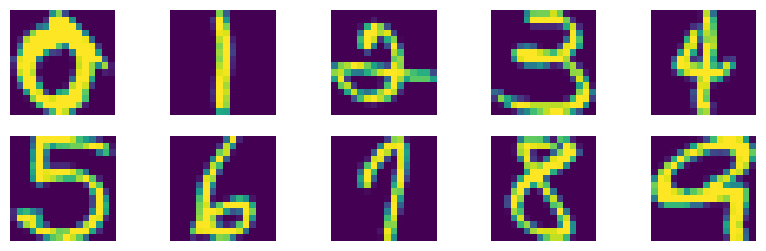

In [197]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')


plt.figure(figsize=(10, 3))
for i in range(10):
        plt.subplot(2, 5, i + 1)
        img_index = img_indices[i][2, 0]
        #print(img_index)
        plt.imshow(x[img_index, :].reshape(16, 16))
        plt.axis('off')


In [5]:
#polynominal_kernel
def Kd(xm, xn, d):
    """
    Parameters:
    xm (array-like): First input matrix.
    xn (array-like): Second input matrix.
    d (int): The degree of the polynomial kernel.

    Returns:
    array-like: Resulting polynomial kernel matrix.
    """
    return (xm @ xn.T) ** d


### OneversusRest

In [201]:
max_iter = 30
min_iter = 5

def polynomial_kernel(xi, xj, degree):
    """
    Polynomial kernel function.
    Args:
        xi, xj: Input vectors.
        degree: Degree of the polynomial.
    
    Returns:
        The polynomial kernel value.
    """
    return np.dot(xi, xj.T) ** degree

def one_versus_rest_classifier(X_data, y_data, degree, kernel_function):
    """
    One-Versus-Rest Multiclass Kernel Perceptron.
    Args:
        X_data: Input feature data.
        y_data: Target labels.
        degree: Degree of the polynomial kernel.
        kernel_function: Kernel function to be used.
    
    Returns:
        weight_matrix: The learned weight matrix.
        accuracy_history: List of accuracies per iteration.
    """
    # Generating the kernel matrix
    kernel_matrix = kernel_function(X_data, X_data, degree)
    
    # Initialising weights
    initial_weights = np.zeros((10, X_data.shape[0]))
    weight_matrix = initial_weights

    # For tracking misclassifications and calculating training accuracy
    misclassify = 0
    accuracy_history = []
    num_samples, _ = X_data.shape

    # Training loop
    for iteration in range(max_iter):
        # Shuffle indices for online learning simulation
        indices = list(range(num_samples))
        np.random.shuffle(indices)

        # Online algorithm processing
        for i in indices:
            # Generating prediction
            predicted_label = np.argmax(weight_matrix @ kernel_matrix[i, :])
            
            # Check correctness and update the model
            if y_data[i] != predicted_label:
                misclassify += 1
                weight_matrix[int(y_data[i]), i] += 1  # Update the correct classifier
                weight_matrix[int(predicted_label), i] -= 1  # Update the incorrect classifier
        
        accuracy_history.append((num_samples - misclassify) / num_samples)
        misclassify = 0

        # Stopping criterion
        if iteration >= min_iter and (accuracy_history[-1] - accuracy_history[-2] < 0.01):
            break

    return weight_matrix, accuracy_history


#### OneVerususOne

In [193]:
import itertools
import numpy as np

# List of binary combinations for 10 classes
binary_combinations = list(itertools.combinations(range(10), 2))

def majorityVoting(classifier_scores):
    """
    Majority voting mechanism for one-vs-one classifier.
    Each classifier votes for a class, and the class with the most votes is chosen.

    :param classifier_scores: Array of scores from binary classifiers.
    :return: Predicted class with the highest vote count.
    """
    vote_count = np.zeros(10)  # Counting votes for each class
    votes = ((np.sign(classifier_scores) + 2) // 2).astype(int)  # Convert scores to binary votes

    for i, vote in enumerate(votes.tolist()):
        vote_count[binary_combinations[i][int(vote)]] += 1  # Count votes for each class

    return np.argmax(vote_count)  # Return class with the highest vote count

def oneVersusOneClassifier(X_data, y_data, degree, kernel_function, max_iter=100):
    """
    One-versus-one classifier using a generalized kernel perceptron.

    :param X_data: Input feature data.
    :param y_data: Target labels.
    :param degree: Degree for the kernel function.
    :param kernel_function: Kernel function used for transformation.
    :param max_iter: Maximum number of iterations for training.
    :return: Trained weights and accuracy history.
    """
    # Generate kernel matrix
    kernel_mtx = kernel_function(X_data, X_data, degree)
    ini_weight = np.zeros((45, X_data.shape[0]))
    accuracy = []
    n, _ = X_data.shape

    weight = ini_weight
    for iteration_count in range(max_iter):
        indices = list(range(n))
        np.random.shuffle(indices)
        error_count = 0

        for i in indices:
            classifier_scores = weight @ kernel_mtx[i, :]
            y_pred = majorityVoting(classifier_scores)  # Making prediction

            if y_pred != y_data[i]:
                error_count += 1

            for index, (p, q) in enumerate(binary_combinations):
                # Adjust weights based on the prediction
                if y_data[i] == p and np.sign(classifier_scores[index]) != -1:
                    weight[index, i] -= 1  # Lower alpha for negative class
                elif y_data[i] == q and np.sign(classifier_scores[index]) != 1:
                    weight[index, i] += 1  # Increase alpha for positive class

        accuracy.append((n - error_count) / n)  # Calculate accuracy for the iteration

        # Stopping criterion based on accuracy improvement
        if iteration_count >= 2 and accuracy[-1] - accuracy[-2] < 0.01:
            break

    return weight, accuracy


In [194]:
def split_data_into_train_test(feature_matrix, target_vector, train_ratio=0.8):
    total_samples = feature_matrix.shape[0]
    train_set_size = int(train_ratio * total_samples)
    shuffled_indices = np.random.permutation(total_samples)
    training_indices, testing_indices = shuffled_indices[:train_set_size], shuffled_indices[train_set_size:]
    training_features, testing_features = feature_matrix[training_indices], feature_matrix[testing_indices]
    training_targets, testing_targets = target_vector[training_indices], target_vector[testing_indices]
    return training_features, training_targets, testing_features, testing_targets



In [195]:

def perform_kfold_cross_validation(features, targets, num_folds):
    total_samples = features.shape[0]
    shuffled_indices = np.random.permutation(total_samples)
    partitioned_indices = np.array_split(shuffled_indices, num_folds)
    fold_data = []

    for fold_index in range(num_folds):
        validation_indices = partitioned_indices[fold_index]
        training_indices = np.setdiff1d(shuffled_indices, validation_indices)
        fold_training_features, fold_validation_features = features[training_indices], features[validation_indices]
        fold_training_targets, fold_validation_targets = targets[training_indices], targets[validation_indices]
        fold_data.append([fold_training_features, fold_training_targets, fold_validation_features, fold_validation_targets])

    return fold_data

### Test_Error and Confusion_Martrix

In [97]:
def test_error_comp(X_train, X_test, y_test, weight, degree, kernel_function):
    # Compute the test kernel matrix
    test_kernel_mtx = kernel_function(X_train, X_test, degree)
    
    # Predict labels
    y_pred = np.argmax(weight @ test_kernel_mtx, axis=0)

    # Calculate error rate
    test_error = np.mean(y_pred != y_test)

    # Constructing the confusion matrix
    confusion_mtx = np.zeros((10, 10))
    for actual, predicted in zip(y_test, y_pred):
        if actual != predicted:
            confusion_mtx[actual, predicted] += 1

    # Normalize the confusion matrix
    row_sums = confusion_mtx.sum(axis=1, keepdims=True)
    confusion_mtx = np.nan_to_num(confusion_mtx / row_sums)

    return test_error, confusion_mtx


### Question 1

In [196]:
import numpy as np
import matplotlib.pyplot as plt

def basic_results(x_data, y_data, kernel_function, gen_method, test_function, plot_image_name=''):
    # Initialize a list to store error data
    error_data = []
    error_data_whole = []
    train_accuracy_whole = []
    # Loop through different degrees or parameters (7 iterations)
    for i in range(7):
        # Initialize lists to store errors for each run
        test_error_list = []
        train_error_list = []
        train_accuracy_list = []
        
        # Determine the degree or parameter based on the kernel function
        if kernel_function == polynomial_kernel:
            degree = i + 1  # Increment degree for polynomial kernel
        else:
            degree = 3 ** (-i - 1)  # Different scaling for other kernels

        # Repeat the process for 20 runs
        for run in range(20):
            # Split the data into training and testing sets
            x_train, y_train, x_test, y_test = split_data_into_train_test(x_data, y_data)
            # Generate model weights and calculate training accuracy
            weight, accuracy = gen_method(x_train, y_train, degree, kernel_function)

            # Test the model, different handling based on test function provided
            if (test_function == test_error_comp) or (test_function ==test_error_comp_onevsone):
                test_error, _ = test_function(x_train, x_test, y_test, weight, degree, kernel_function)
            else:
                test_error = test_function(x_train, x_test, y_test, weight, degree, kernel_function)

            # Store the calculated errors
            test_error_list.append(test_error)
            train_error_list.append(1 - accuracy[-1])
            train_accuracy_list.append(accuracy)
            
        # Calculate and store the mean and standard deviation of errors
        #error_data.append([np.mean(train_error_list), np.std(train_error_list), np.mean(test_error_list), np.std(test_error_list)])
        error_data_whole.append([np.array(train_error_list), np.array(test_error_list)])
        error_data.append([np.mean(train_error_list), np.std(train_error_list), np.mean(test_error_list), np.std(test_error_list)])
        train_accuracy_whole.append(train_accuracy_list)
        
    # Convert error data to percentages and round off
    error_data = [np.round(np.array([mean_train, std_train, mean_test, std_test]) * 100, 3) for mean_train, std_train, mean_test, std_test in error_data]

    # Convert error data to percentages and round off
    #error_data = (np.array(error_data) * 100).round(3)
    
    # Print the error data in a table format
    print("Degree | Train Error (Mean ± SD) | Test Error (Mean ± SD)")
    for degree, errors in enumerate(error_data, start=1):
        print(f"{degree}      | {errors[0]:.3f} ± {errors[1]:.3f}        | {errors[2]:.3f} ± {errors[3]:.3f}")

    # Call the function to plot the errors
    plot_errors(np.array(error_data), plot_image_name = plot_image_name)

    # Return the compiled error data
    return error_data, (error_data_whole, train_accuracy_whole)

def plot_errors(data, plot_image_name = ''):
    # Define the degrees/parameters for the x-axis
    degrees = range(1, 8)
    # Extract training and testing errors from the data
    train_errors = data[:, 0]
    test_errors = data[:, 2]

    # Plotting setup
    plt.figure(figsize=(10, 5))
    plt.plot(degrees, train_errors, label='Train Error')  # Plot training errors
    plt.plot(degrees, test_errors, label='Test Error')    # Plot testing errors
    plt.xlabel('Degree/Parameter')  # x-axis label
    plt.ylabel('Error (%)')         # y-axis label
    #plt.title('Train vs Test Error')  # Chart title
    plt.legend()                     # Show legend
    if len(plot_image_name) > 0:
        plt.savefig(plot_image_name)
        print(f'Image saved as {plot_image_name}')
    plt.show()                       # Display the plot


/var/folders/lb/41rls4rj0x326nd16_n_dw4h0000gn/T/ipykernel_62183/4074424868.py:19: RuntimeWarning: invalid value encountered in divide
  confusion_mtx = np.nan_to_num(confusion_mtx / row_sums)


Degree | Train Error (Mean ± SD) | Test Error (Mean ± SD)
1      | 6.239 ± 0.311        | 8.384 ± 1.357
2      | 0.479 ± 0.107        | 3.809 ± 0.447
3      | 0.186 ± 0.114        | 3.099 ± 0.317
4      | 0.086 ± 0.057        | 3.035 ± 0.395
5      | 0.077 ± 0.063        | 3.269 ± 0.341
6      | 0.047 ± 0.032        | 3.323 ± 0.414
7      | 0.066 ± 0.036        | 3.379 ± 0.740
Image saved as cw2_1.jpg


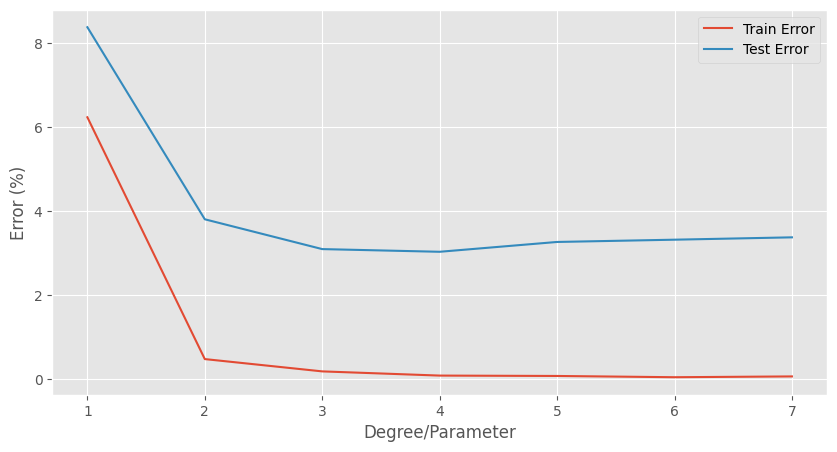

670.2988028526306

In [199]:
# Adding a timer to measure the execution time of the provided code snippet
import time
import uuid
# Assuming Q1_function, x, y, poly_kernel, and multiclassOvR are defined elsewhere,
# since they are not provided in the snippet

# Start the timer
start_time = time.time()

plot_image_name = 'cw2_1.jpg'#f'basic_result_{str(uuid.uuid4())}.jpg'

Q1_train_test_error, (Q1_train_test_error_whole, Q1_train_accuracy_whole) = basic_results(x,y, polynomial_kernel, one_versus_rest_classifier, \
                                                               test_function = test_error_comp,\
                                                                plot_image_name = plot_image_name)
Q1_train_test_error

# Stop the timer
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

execution_time  # Display the execution time

/var/folders/lb/41rls4rj0x326nd16_n_dw4h0000gn/T/ipykernel_62183/637947303.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:len(Q1_train_accuracy_whole)])


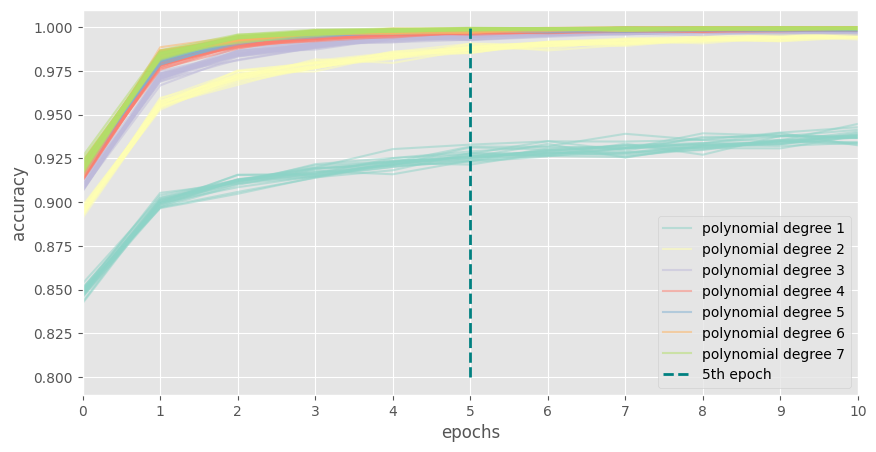

In [265]:
import matplotlib
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:len(Q1_train_accuracy_whole)])

plt.figure(figsize = (10,5))
for j in range(len(Q1_train_accuracy_whole)):#classes
    for i in Q1_train_accuracy_whole[j][:][:]:
        plt.plot(i, color=cmap(j), label=f'polynomial degree {j+1}', alpha= 0.5)
plt.vlines(x=[5], ymin=[0.8], ymax=[1], colors='teal', ls='--', lw=2, label='5th epoch')
handles, labels = plt.gca().get_legend_handles_labels()
temp = {k:v for k,v in zip(labels, handles)}
plt.xticks(np.arange(0,len(i)))
plt.xlim(0,len(i)-1)
plt.legend(temp.values(), temp.keys(), loc='best')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('training_epochs.jpg')

### Question_2 & Question_3

In [209]:
def test_error_comp_onevsone(X_training_data, X_testing_data, y_testing_data, model_weights, degree_of_kernel, kernel_func):
    """
    Calculate the test error and construct a normalized confusion matrix for a one-versus-one classification problem.

    Parameters:
    X_training_data : array-like
        Training data features used to compute the kernel matrix.
    X_testing_data : array-like
        Testing data features for which predictions are to be made.
    y_testing_data : array-like
        True labels of the testing data.
    model_weights : array-like
        Weights of the trained model.
    degree_of_kernel : int
        Degree or parameter of the kernel function.
    kernel_func : function
        Kernel function used to compute the kernel matrix.

    Returns:
    float
        The calculated test error rate.
    np.ndarray
        The normalized confusion matrix.
    """

    # Compute the kernel matrix for testing data
    test_kernel_matrix = kernel_func(X_training_data, X_testing_data, degree_of_kernel)

    # Initialize an array to store predictions
    predicted_labels = np.zeros(len(y_testing_data))

    # Generating prediction for each test instance using the voting function
    for index in range(len(y_testing_data)):
        predicted_labels[index] = majorityVoting(model_weights @ test_kernel_matrix[:, index])

    # Convert predicted labels to integer type
    predicted_labels = predicted_labels.astype(int)

    # Calculate the test error as the fraction of misclassified instances
    test_error = np.sum(predicted_labels != y_testing_data) / len(y_testing_data)

    # Constructing the confusion matrix
    confusion_mtx = np.zeros((10, 10))  # Assuming 10 classes
    for actual, predicted in zip(y_testing_data, predicted_labels):
        confusion_mtx[actual, predicted] += 1

    # Normalize the confusion matrix
    row_sums = confusion_mtx.sum(axis=1, keepdims=True)
    normalized_confusion_mtx = np.nan_to_num(confusion_mtx / row_sums)

    return test_error, normalized_confusion_mtx


In [210]:
def model_performance(feature_data, target_data, kernel_func, model_generator, evaluation_func):
    
    evaluation_results = []
    confusion_arrays = []
    for iteration in range(20):
        # Data splitting for k-fold
        training_features, training_labels, testing_features, testing_labels = split_data_into_train_test(feature_data, target_data)
        validation_folds = perform_kfold_cross_validation(training_features, training_labels, 5)
        fold_evaluations = []

        for degree_index in range(7):
            fold_errors = []

            # Assigning degree based on kernel function
            if kernel_func != polynomial_kernel:
                current_degree = 3 ** (-degree_index - 1)
            else:
                current_degree = degree_index + 1

            for fold_index in range(5):
                # k-fold training and validation
                train_x, train_y, validate_x, validate_y = validation_folds[fold_index]
                model_weight, _ = model_generator(train_x, train_y, current_degree, kernel_func)

                # Error calculation based on evaluation method
                if evaluation_func == test_error_comp or evaluation_func == test_error_comp_onevsone:  # OvR generalization
                    error = evaluation_func(train_x, validate_x, validate_y, model_weight, current_degree, kernel_func)[0]
                else:  # OvO generalization
                    error = evaluation_func(train_x, validate_x, validate_y, model_weight, current_degree, kernel_func)

                fold_errors.append(error)

            fold_evaluations.append(np.mean(fold_errors))

        # Optimal degree determination
        if kernel_func != polynomial_kernel:
            optimal_degree = np.power(3.0, -np.argmin(fold_evaluations) - 1)
        else:
            optimal_degree = np.argmin(fold_evaluations) + 1

        optimal_model_weight, _ = model_generator(training_features, training_labels, optimal_degree, kernel_func)

        # Evaluation and results aggregation
        if evaluation_func == test_error_comp:  # OvR generalization
            success_rate, confusion_matrix = evaluation_func(training_features, testing_features, testing_labels, optimal_model_weight, optimal_degree, kernel_func)
            evaluation_results.append([optimal_degree, success_rate])
            confusion_arrays.append(confusion_matrix)
            
        else:  # OvO generalization
            success_rate,confusion_matrix = evaluation_func(training_features, testing_features, testing_labels, optimal_model_weight, optimal_degree, kernel_func)
            evaluation_results.append([optimal_degree, success_rate])

    # Returning results based on the evaluation function used
    if evaluation_func == test_error_comp:
        return np.array(evaluation_results), np.array(confusion_arrays)
    else:
        return np.array(evaluation_results)


In [211]:
import time
start_time = time.time()
Q2_data, Q3_data = model_performance(x,y,polynomial_kernel,model_generator=one_versus_rest_classifier, evaluation_func=test_error_comp)
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

execution_time 

/var/folders/lb/41rls4rj0x326nd16_n_dw4h0000gn/T/ipykernel_62183/4074424868.py:19: RuntimeWarning: invalid value encountered in divide
  confusion_mtx = np.nan_to_num(confusion_mtx / row_sums)


1668.2393929958344

In [212]:
test_error = np.array(Q2_data)
test_error[:, -1] *= 100

# Formatting and printing the table
print("Degree\t Test Error Rate (%)")
for row in test_error:
    #print("\t".join(f"{value:.2f}" for value in row))
    print(f'{int(row[0])} \t {row[1]:.2f}')

avg_degree, avg_error_rate = np.mean(test_error, axis=0)
std_degree, std_error_rate = np.std(test_error, axis=0)

print(f"\nAverage Degree: {avg_degree:.2f}, Standard Deviation: {std_degree:.2f}")
print(f"Average Test Error Rate (%): {avg_error_rate:.2f}, Standard Deviation: {std_error_rate:.2f}")



Degree	 Test Error Rate (%)
5 	 3.33
4 	 3.98
5 	 3.33
4 	 3.17
6 	 3.76
5 	 3.28
7 	 3.71
7 	 3.66
4 	 4.57
6 	 3.33
5 	 3.23
6 	 3.49
5 	 3.49
5 	 2.74
7 	 3.33
4 	 3.49
6 	 3.28
7 	 2.31
6 	 2.74
5 	 3.60

Average Degree: 5.45, Standard Deviation: 1.02
Average Test Error Rate (%): 3.39, Standard Deviation: 0.46


In [271]:
Q3_data.shape

(20, 10, 10)

In [272]:
print(np.mean(Q3_data, axis =0).round(3))
print(np.std(Q3_data, axis =0).round(3))

[[0.    0.    0.15  0.115 0.151 0.174 0.234 0.025 0.134 0.017]
 [0.    0.    0.043 0.083 0.361 0.    0.22  0.103 0.08  0.01 ]
 [0.159 0.04  0.    0.153 0.246 0.043 0.026 0.182 0.139 0.012]
 [0.066 0.028 0.148 0.    0.01  0.403 0.    0.056 0.206 0.083]
 [0.04  0.215 0.113 0.    0.    0.041 0.158 0.073 0.017 0.344]
 [0.162 0.01  0.08  0.204 0.153 0.    0.156 0.022 0.133 0.081]
 [0.236 0.097 0.075 0.    0.321 0.156 0.    0.    0.065 0.   ]
 [0.01  0.096 0.143 0.067 0.29  0.    0.    0.    0.055 0.34 ]
 [0.093 0.115 0.147 0.2   0.07  0.169 0.092 0.043 0.    0.071]
 [0.014 0.02  0.048 0.094 0.495 0.013 0.003 0.236 0.027 0.   ]]
[[0.    0.    0.187 0.175 0.296 0.185 0.239 0.109 0.258 0.05 ]
 [0.    0.    0.127 0.255 0.384 0.    0.367 0.243 0.148 0.037]
 [0.131 0.075 0.    0.117 0.14  0.081 0.069 0.141 0.159 0.054]
 [0.073 0.058 0.115 0.    0.03  0.222 0.    0.109 0.113 0.217]
 [0.073 0.139 0.138 0.    0.    0.074 0.134 0.089 0.041 0.275]
 [0.138 0.044 0.119 0.135 0.132 0.    0.124 0.045 0.10

<Axes: >

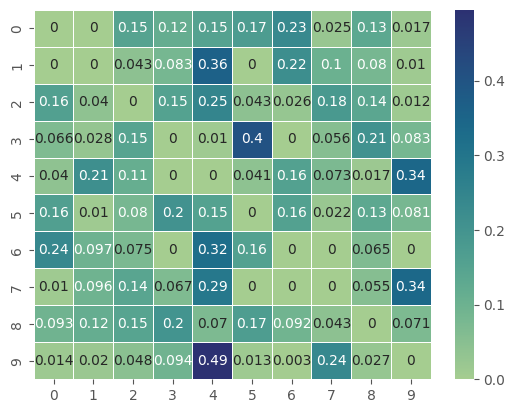

In [273]:
#import seaborn as sns
#sns.heatmap(np.mean(Q3_data, axis =0).round(3), annot=True, linewidth=.5, cmap='crest')

### Question_4

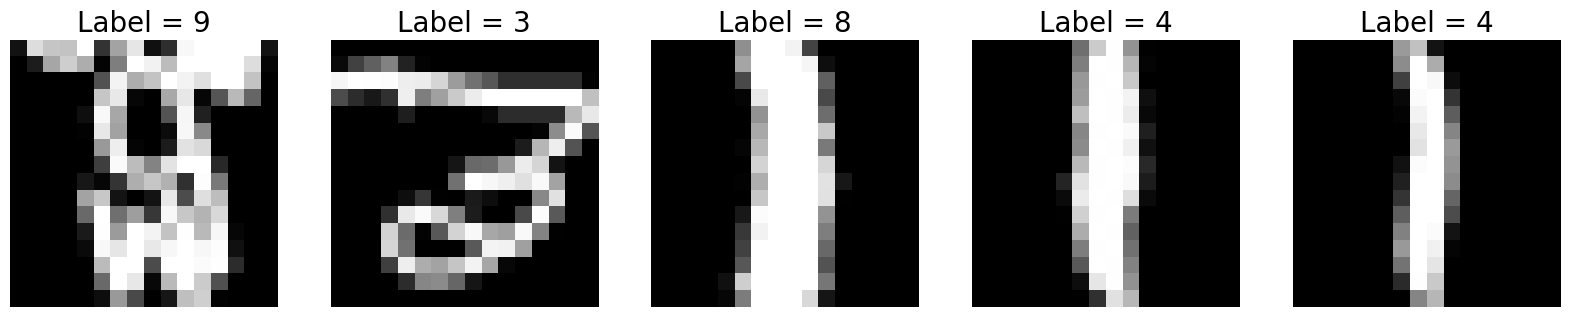

In [274]:
import numpy as np
import matplotlib.pyplot as plt

misclassification_counts = np.zeros_like(y)

# Running the classification process multiple times
for iteration in range(40):
    # Splitting the data for training and testing
    features_train, labels_train, features_test, labels_test = split_data_into_train_test(x,y)
    model_weights, _ = one_versus_rest_classifier(features_train, labels_train, 6, polynomial_kernel)
    
    # Prediction phase
    kernel_matrix = polynomial_kernel(features_train, x,6)
    predicted_labels = np.argmax(model_weights @ kernel_matrix, axis=0)
    
    # Counting misclassifications
    misclassification_counts[np.argwhere(predicted_labels != y)] += 1

# Identifying the images that are most frequently misclassified
most_misclassified = np.argsort(misclassification_counts)[-5:]



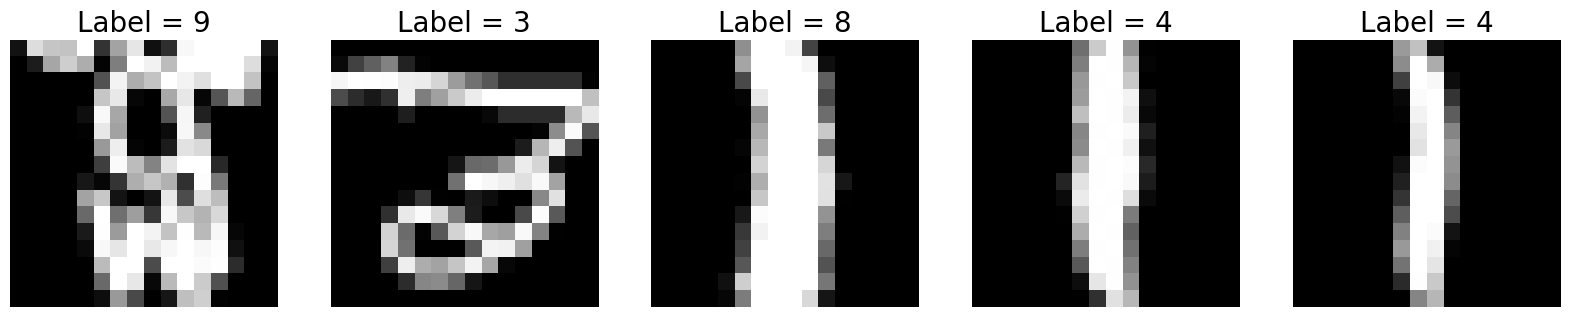

In [289]:

# Visualizing the most misclassified images
plt.figure(figsize=(20, 8))
for index, image_index in enumerate(most_misclassified):
    plt.subplot(1, 5, index + 1)
    plt.imshow(x[image_index, :].reshape(16, 16),cmap = "gray")
    plt.title(f'Label = {int(y[image_index])}', fontsize=20)
    plt.axis('off')
    
plt.savefig('cw2_4.jpg', dpi=200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Question_5

In [216]:
def kernel_gaussian(xi, xj, c):
    # Calculate squared norms of each row in xi and xj
    xi_norm = np.sum(xi**2, axis=-1)
    xj_norm = np.sum(xj**2, axis=-1)

    # Efficiently calculate the distance matrix
    distance_matrix = xi_norm[:, None] + xj_norm[None, :] - 2 * np.dot(xi, xj.T)

    # Apply the Gaussian function
    return np.exp(-c * distance_matrix)


/var/folders/lb/41rls4rj0x326nd16_n_dw4h0000gn/T/ipykernel_62183/4074424868.py:19: RuntimeWarning: invalid value encountered in divide
  confusion_mtx = np.nan_to_num(confusion_mtx / row_sums)


Degree | Train Error (Mean ± SD) | Test Error (Mean ± SD)
1      | 0.000 ± 0.000        | 5.989 ± 0.553
2      | 0.009 ± 0.015        | 5.091 ± 0.562
3      | 0.040 ± 0.033        | 3.449 ± 0.459
4      | 0.203 ± 0.095        | 3.145 ± 0.355
5      | 1.250 ± 0.134        | 4.468 ± 1.083
6      | 5.501 ± 0.259        | 7.444 ± 1.645
7      | 9.573 ± 0.361        | 9.562 ± 1.874


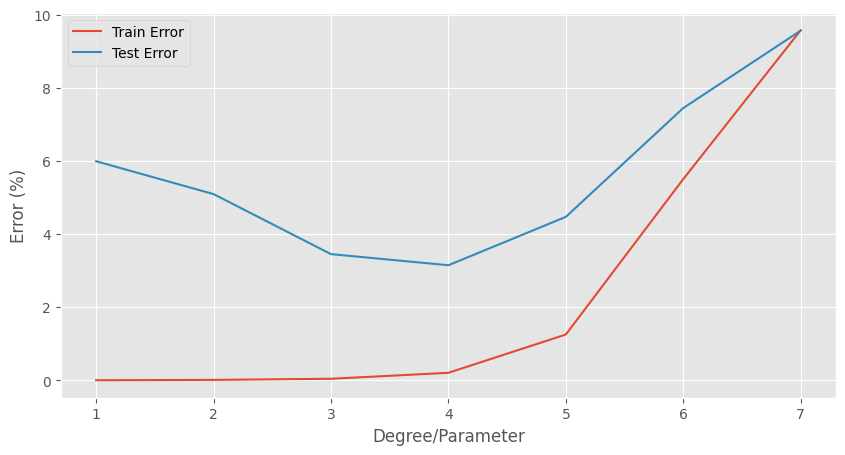

[array([0.   , 0.   , 5.989, 0.553]), array([0.009, 0.015, 5.091, 0.562]), array([0.04 , 0.033, 3.449, 0.459]), array([0.203, 0.095, 3.145, 0.355]), array([1.25 , 0.134, 4.468, 1.083]), array([5.501, 0.259, 7.444, 1.645]), array([9.573, 0.361, 9.562, 1.874])]


In [217]:
GaussQ1_error, _ = basic_results(x,y,kernel_gaussian,one_versus_rest_classifier,test_error_comp)
print(GaussQ1_error)

Image saved as cw2_q5.jpg


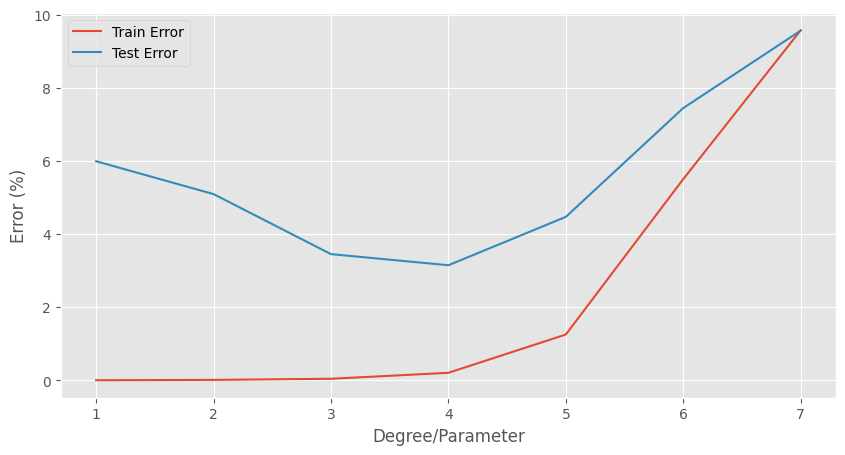

In [281]:
plot_errors(np.array(GaussQ1_error), plot_image_name = 'cw2_q5.jpg')

In [218]:
GaussQuestion2 = model_performance(x,y,kernel_gaussian,one_versus_rest_classifier,test_error_comp)

/var/folders/lb/41rls4rj0x326nd16_n_dw4h0000gn/T/ipykernel_62183/4074424868.py:19: RuntimeWarning: invalid value encountered in divide
  confusion_mtx = np.nan_to_num(confusion_mtx / row_sums)


In [276]:
# Assuming GaussQ2_table is defined and contains the desired data
gaussian_results = np.array(GaussQuestion2[0])
gaussian_results[:, -1] *= 100  # Convert last column to percentage

print(gaussian_results.round(3))  # Print with rounding to 3 decimal places
print(gaussian_results.round(3)[:,1])

[[0.012 2.742]
 [0.012 3.011]
 [0.012 3.011]
 [0.012 2.849]
 [0.037 3.441]
 [0.012 2.634]
 [0.037 2.903]
 [0.012 2.366]
 [0.012 2.204]
 [0.012 3.011]
 [0.012 3.226]
 [0.012 2.527]
 [0.012 3.226]
 [0.012 2.903]
 [0.012 2.796]
 [0.012 3.602]
 [0.012 3.226]
 [0.012 3.387]
 [0.012 3.011]
 [0.012 3.441]]
[2.742 3.011 3.011 2.849 3.441 2.634 2.903 2.366 2.204 3.011 3.226 2.527
 3.226 2.903 2.796 3.602 3.226 3.387 3.011 3.441]


In [220]:
Q2_data.shape

(20, 2)

In [221]:
GaussQuestion2[0].shape

(20, 2)

In [278]:
test_error = np.array(GaussQuestion2[0])
test_error[:, -1] *= 100

# Formatting and printing the table
print("Degree\t Test Error Rate (%)")
for row in test_error:
    print("\t".join(f"{value:.4f}" for value in row))

avg_degree, avg_error_rate = np.mean(test_error, axis=0)
std_degree, std_error_rate = np.std(test_error, axis=0)

print(f"\nAverage Degree: {avg_degree:.4f}, Standard Deviation: {std_degree:.4f}")
print(f"Average Test Error Rate (%): {avg_error_rate:.4f}, Standard Deviation: {std_error_rate:.4f}")



Degree	 Test Error Rate (%)
0.0123	2.7419
0.0123	3.0108
0.0123	3.0108
0.0123	2.8495
0.0370	3.4409
0.0123	2.6344
0.0370	2.9032
0.0123	2.3656
0.0123	2.2043
0.0123	3.0108
0.0123	3.2258
0.0123	2.5269
0.0123	3.2258
0.0123	2.9032
0.0123	2.7957
0.0123	3.6022
0.0123	3.2258
0.0123	3.3871
0.0123	3.0108
0.0123	3.4409

Average Degree: 0.0148, Standard Deviation: 0.0074
Average Test Error Rate (%): 2.9758, Standard Deviation: 0.3596


### Question 6

Degree | Train Error (Mean ± SD) | Test Error (Mean ± SD)
1      | 5.486 ± 0.609        | 7.003 ± 0.878
2      | 1.550 ± 0.297        | 4.266 ± 0.520
3      | 0.827 ± 0.202        | 3.718 ± 0.438
4      | 0.540 ± 0.199        | 3.522 ± 0.422
5      | 0.475 ± 0.231        | 3.452 ± 0.354
6      | 0.296 ± 0.049        | 3.661 ± 0.393
7      | 0.247 ± 0.060        | 3.535 ± 0.342


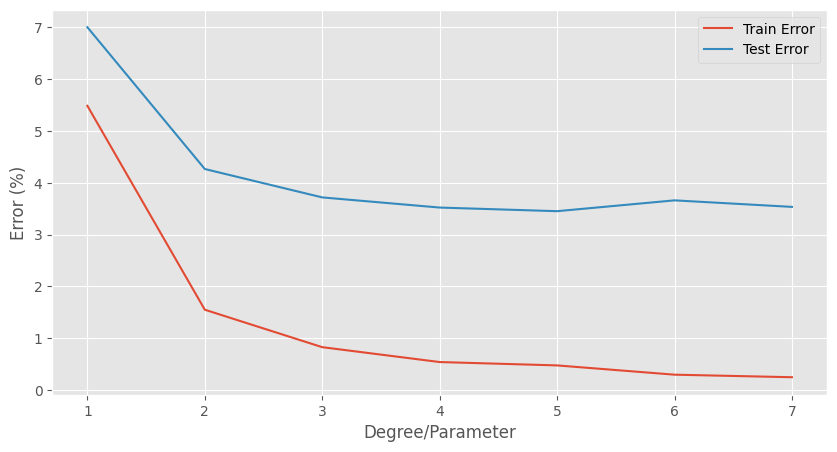

[array([5.486, 0.609, 7.003, 0.878]), array([1.55 , 0.297, 4.266, 0.52 ]), array([0.827, 0.202, 3.718, 0.438]), array([0.54 , 0.199, 3.522, 0.422]), array([0.475, 0.231, 3.452, 0.354]), array([0.296, 0.049, 3.661, 0.393]), array([0.247, 0.06 , 3.535, 0.342])]


In [223]:
min_iter = 3
Q6_I_data, _ = basic_results(x,y, polynomial_kernel, oneVersusOneClassifier, test_function=test_error_comp_onevsone)
print(Q6_I_data)

Image saved as cw2_q6.jpg


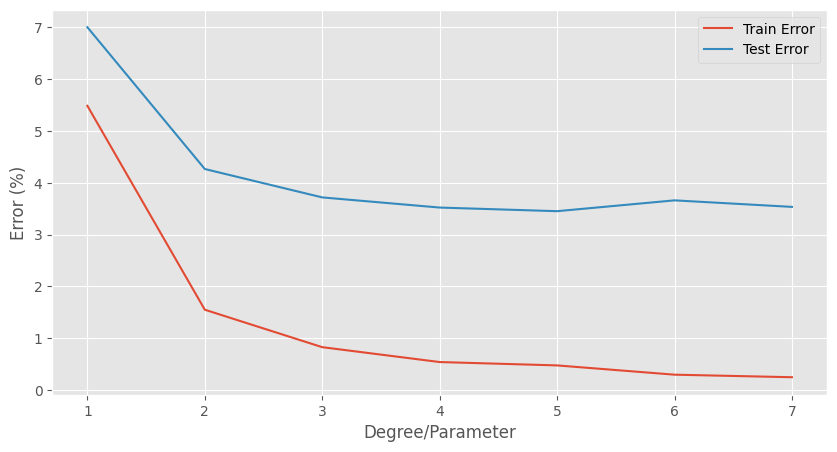

In [282]:
plot_errors(np.array(Q6_I_data), plot_image_name = 'cw2_q6.jpg')

In [224]:
que_6_data = model_performance(x,y, polynomial_kernel, oneVersusOneClassifier, test_error_comp_onevsone)

In [286]:
test_error = np.array(que_6_data)
test_error[:, -1] *= 100

# Formatting and printing the table
print("Degree\t Test Error Rate (%)")
for row in test_error:
    #print("\t".join(f"{value:.4f}" for value in row))
    print(f'{int(row[0])} \t {row[1]:.4f}')

avg_degree, avg_error_rate = np.mean(test_error, axis=0)
std_degree, std_error_rate = np.std(test_error, axis=0)

print(f"\nAverage Degree: {avg_degree:.4f}, Standard Deviation: {std_degree:.4f}")
print(f"Average Test Error Rate (%): {avg_error_rate:.4f}, Standard Deviation: {std_error_rate:.4f}")



Degree	 Test Error Rate (%)
5 	 2.8495
4 	 3.2796
5 	 2.8495
6 	 3.4946
4 	 3.1183
5 	 3.4946
6 	 3.3333
4 	 3.1720
5 	 3.1720
6 	 3.4409
5 	 3.4946
5 	 3.4946
4 	 3.1183
6 	 3.0645
4 	 3.7097
4 	 3.0645
5 	 3.8172
5 	 3.2796
4 	 3.2258
3 	 2.5269

Average Degree: 4.7500, Standard Deviation: 0.8292
Average Test Error Rate (%): 3.2500, Standard Deviation: 0.2981
